# Test AtmosphericExtinction

In [1]:
import numpy as np
import pandas as pd
import os
from scipy import interpolate
from astropy.io import fits
from astropy.table import Table
from scipy.interpolate import RegularGridInterpolator
import pickle
import seaborn as sns
import copy
import astropy.io.fits as F

In [2]:
#import sys
#sys.path.append(".") 

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# to enlarge the sizes
params = {'legend.fontsize': 'large',
          'figure.figsize': (16, 8),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)


In [4]:
from pyExtinction.AtmosphericExtinction import ExtinctionModel,EXT2OPT

In [5]:
WL = np.arange(300.,1100.)

In [6]:
model = ExtinctionModel(WL*10.)

In [7]:
press = 743
o3 = 600.
tau = 0.05
ang = 1.3

In [8]:
pars = np.array([press,o3,tau,ang])

In [9]:
label1='Rayleigh [%.0f mbar]' % press
label2='Ozone [%.0f DU]' % o3
label3=u'Aerosols [τ=%.4f, å=%.2f]' % (tau, ang)
all_labels = [label1,label2,label3]

# Plot Extinction directly from modem

In [10]:
model.setParams(pars, dpars=None)

<Axes: title={'center': 'SNfactory atmospheric transmission (Buton et al., 2013A&A...549A...8B)'}, xlabel='Wavelength [Å]', ylabel='Transmission'>

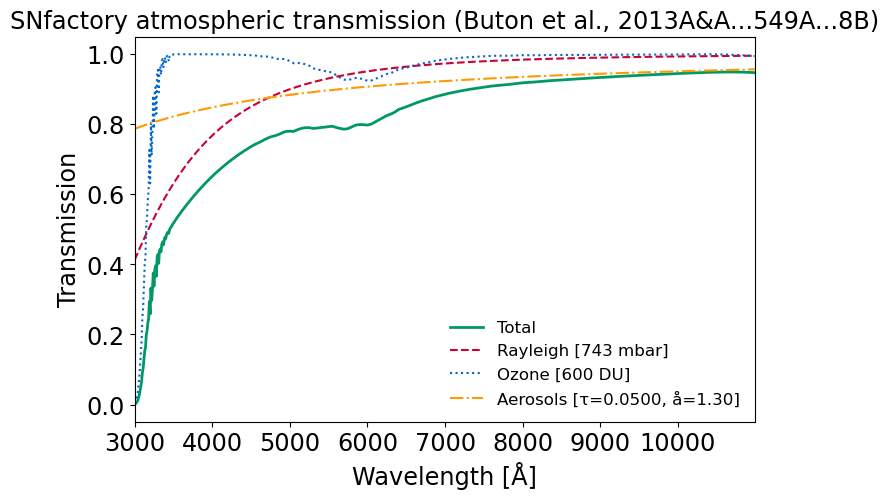

In [11]:
model.plot(transmission=True)

In [12]:
# Default ozone template
#O3Template = os.path.join(os.path.dirname(os.path.abspath(__file__)),'data/ozoneTemplate.fits')
O3Template = 'pyExtinction/data/ozoneTemplate.fits'

In [13]:
def readOzoneTemplatexy(ozoneName,
                      colLbda='LAMBDA', colTrans='OZONE', ext=1):
    """
    Read ozone transmission template, interpolate over
    wavelengthes, and convert to extinction [mag/airmass].

    :param ozoneName: input FITS table, with columns *colLbda*
      (wavelength in AA) and *colTrans* (fractional transmission), and
      key 'REFO3COL' specifing the reference ozone column density [DU]
    :param lbda: output wavelengthes [AA]
    :param colLbda: name of the wavelength (in AA) column
    :param colTrans: name of the ozone transmission column
    :param ext: extension in which to look for wavelength and
      transmission columns
    :return: ozone extinction [mag/airmass], refO3col
    """

    # Read wavelength and transmission columns
    ffile = F.open(ozoneName)
    x = ffile[ext].data.field(colLbda)   # Wavelength
    y = ffile[ext].data.field(colTrans)  # Transmission
    refO3col = ffile[ext].header["REFO3COL"]
    return x,y,refO3col

In [14]:
xozref,yozref,refO3col = readOzoneTemplatexy(O3Template)
labeloz_ref = f"ozone ref {refO3col} DU"

# Plot myself transmission

In [15]:
components_extinctions = model.extinctionComponents()

In [16]:
model.__str__()

'Wavelength domain: 3000.0-10990.0 A by step of 10.0 A (800 px)\nOzone template: /Users/sylvie/MacOSX/GitHub/LSST/AtmosphericSimulation/AtmEmulator/SimpleEmulator/pyExtinction/data/ozoneTemplate.fits (265.0 DU)\nAerosol reference wavelength: 10000 A\nInput extinction parameters:\n  Pressure: 743 +/- 0 mbar\n  Ozone:    600 +/- 0 DU\n  Aerosols: optical depth @ refLbda: 0.05 +/- 0\n            angstrom exponent:         1.30 +/- 0.00\n'

In [17]:
ncomp = components_extinctions.shape[0]

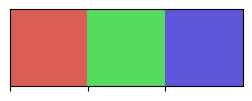

In [18]:
hls_colors = sns.color_palette("hls", ncomp)
sns.palplot(hls_colors)

In [19]:
rayleigh_extinction = components_extinctions[0,:]
ozone_extinction = components_extinctions[1,:]
aerosol_extinction = components_extinctions[2,:]
rayleigh_opticalindex = EXT2OPT * rayleigh_extinction 
ozone_opticalindex = EXT2OPT * ozone_extinction 
aerosol_opticalindex = EXT2OPT * aerosol_extinction 
all_optical_indexes = [rayleigh_opticalindex,ozone_opticalindex ,aerosol_opticalindex]

Text(0.5, 0, '$\\lambda$ (nm)')

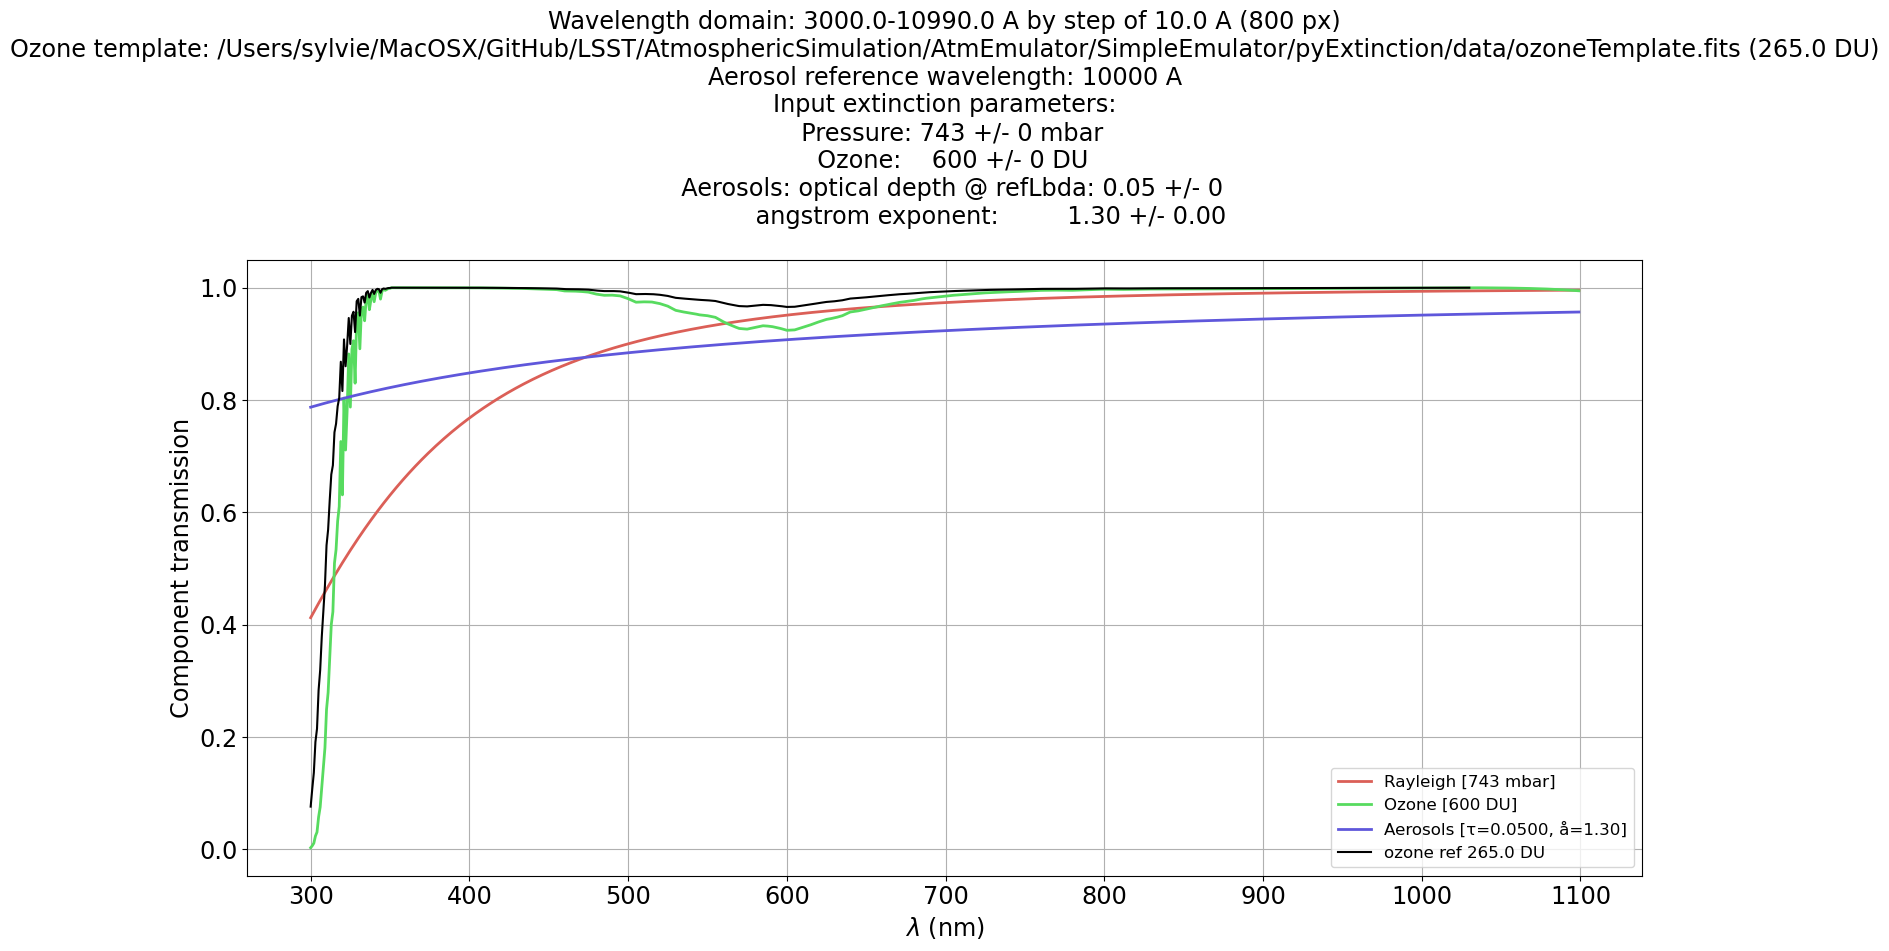

In [20]:
fig = plt.figure(figsize=(18,8))
ax=fig.add_subplot()

for idx in range(ncomp):
    ax.plot(WL,np.exp(-all_optical_indexes[idx]),color=hls_colors[idx],label=all_labels[idx],lw=2) 

ax.grid()


ax.plot(xozref/10,yozref,color="k",label=labeloz_ref)
ax.legend()
ax.set_title(model.__str__())
ax.set_ylabel("Component transmission")
ax.set_xlabel("$\\lambda$ (nm)")